In [3]:
rm(list=ls())

if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, srvyr,showtext)
#Fuente para los gráficos
font_add_google("Poppins", "pop")
showtext_auto()

Cargando paquete requerido: pacman



In [4]:
#Crear directorio para guardar los archivos
dir.create("enif", showWarnings = FALSE)

In [5]:
url<-"https://www.inegi.org.mx/contenidos/programas/enif/2024/datosabiertos/conjunto_de_datos_enif_2024_csv.zip"
temp <- tempfile()
download.file(url,
              mode = "wb",
              destfile = temp)
unzip(temp, exdir = "enif")
unlink(temp)

In [6]:
##Hogares
hogares <- read_csv(
  "enif/conjunto_de_datos_thogar_enif_2024/conjunto_de_datos/conjunto_de_datos_thogar_enif2024.csv",
  col_types = cols(
    llaveviv = col_character(),
    llavehog = col_character()
  )
) %>%
  mutate(
    llaveviv = str_pad(llaveviv, width = 7, side = "left", pad = "0"),
    llavehog = str_pad(llavehog, width = 8, side = "left", pad = "0")
  )

  head(hogares,10)


llavehog,llaveviv,p2_8,folio,viv_sel,hogar,est_dis,upm_dis,fac_hog
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
00001011,0000101,1,1,1,1,17,196,633
00002101,0000210,1,2,10,1,179,2088,1811
00003031,0000303,2,3,3,1,50,763,485
00004011,0000401,1,4,1,1,17,182,739
00005031,0000503,1,5,3,1,49,631,3756
00006031,0000603,0,6,3,1,40,459,4568
00007041,0000704,0,7,4,1,111,1380,3726
00008031,0000803,2,8,3,1,135,1585,1797
00009041,0000904,2,9,4,1,107,1297,3504


In [37]:
#Datos de ahorro por persona

modulo<-read_csv("enif/conjunto_de_datos_tmodulo_enif_2024/conjunto_de_datos/conjunto_de_datos_tmodulo_enif2024.csv")%>%
janitor::clean_names()%>%
#Clasificación por tipo de ahorro
##Ahorro informal
mutate(ahorro_inf=case_when( 
(p5_1_1 == 1 | p5_1_2==1 | p5_1_3==1 | p5_1_4==1 | p5_1_5==1 | p5_1_6==1 ) ~ 1,
TRUE ~ 0),
## Ahorro formal
ahorro_form=case_when((p5_6_1==1 | p5_6_2==1 | p5_6_3==1 | p5_6_4==1 | p5_6_5==1 | p5_6_6==1 | p5_6_7==1 | p5_6_8==1 | p5_6_9==1 
) ~ 1,
TRUE ~ 0),
##Ahorra, ya sea de manera formal o informal
accion_ahorro=case_when(ahorro_form==1 | ahorro_inf==1 ~ 1,TRUE ~ 0),
#Clasificación por tiempo de cobertura de gastos
cubre_gastos=
case_when(p4_10==1 ~ "Menos de una semana/ No tiene ahorros",
p4_10==2 ~ "Al menos una semana, pero menos de un mes",
p4_10==3 ~ "Al menos un mes, pero menos de tres meses",
p4_10==4 ~ "Al menos tres meses, pero menos de seis meses",
p4_10==5 ~ "Seis meses o más",
p4_10==8 ~ "No responde",
p5_10==9 ~ "No sabe",
TRUE ~ "No aplica"),

#Equivalencia de ahorro en ingreso
equivalencia=
case_when(p5_3== 1 ~ "una semana",
p5_3== 2 ~ "una quincena",
p5_3== 3 ~ "un mes",
p5_3== 4 ~ "más de un mes",
TRUE ~ "No sabe/No contestó"

),
cond_ocup=case_when(
  (p3_8==1 | p3_8==2) ~ "Ocupada",
  (p3_8==3 | p3_8==4) ~ "Desocupada",
  TRUE ~ "No economicamente activa"
))

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 13502 Columns: 398
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (23): llavemod, llaveviv, llavehog, niv, p3_11a, p3_15_epc, p3_15_muc, ...
dbl (373): edad_v, gra, p3_1a, p3_2, p3_3, p3_4, p3_5_1, p3_5_2, p3_5_3, p3_...
lgl   (2): p6_4_3, p6_4_9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [38]:
#Diseño muestral
dmpers<-modulo%>%
as_survey_design(ids = "upm_dis",
            weights = "fac_per",
            strata="est_dis")

In [43]:
dmpers%>%
filter(cond_ocup!="No economicamente activa")%>%
group_by(cond_ocup)%>%
summarise(personas=survey_total(vartype = "cv"),
pct=survey_prop(vartype = "cv"))%>%
mutate(pct=round(pct*100,2))

cond_ocup,personas,personas_cv,pct,pct_cv
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Desocupada,1140014,0.11235121,1.83,0.111043472
Ocupada,61059661,0.01357363,98.17,0.002073236


In [9]:
#Total de personas de 18 años y más
dmpers%>%
summarise(personas=survey_total(vartype = "cv"))

personas,personas_cv
<dbl>,<dbl>
94221441,0.009911919


In [10]:
#Acción de ahorro; ya sea formal o informal
ahorro<-dmpers%>%
group_by(accion_ahorro)%>%
summarise(personas=survey_total(vartype = "cv"),
          pct=survey_prop(vartype = "cv"))%>%
mutate(pct=round(pct*100,1))%>%
janitor::adorn_totals("row")
ahorro

accion_ahorro,personas,personas_cv,pct,pct_cv
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,33723779,0.01988659,35.8,0.01767772
1,60497662,0.01427815,64.2,0.00985426
Total,94221441,0.03416474,100.0,0.02753198


equivalencia,personas,personas_cv,pct,pct_cv
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
una semana,6314303,0.05309771,10.4,0.05130590
una quincena,8023234,0.04380105,13.3,0.04133318
un mes,13465908,0.03581465,22.3,0.03286855
más de un mes,23211431,0.02626869,38.4,0.02159691
No sabe/No contestó,9482786,0.04158558,15.7,0.03956993


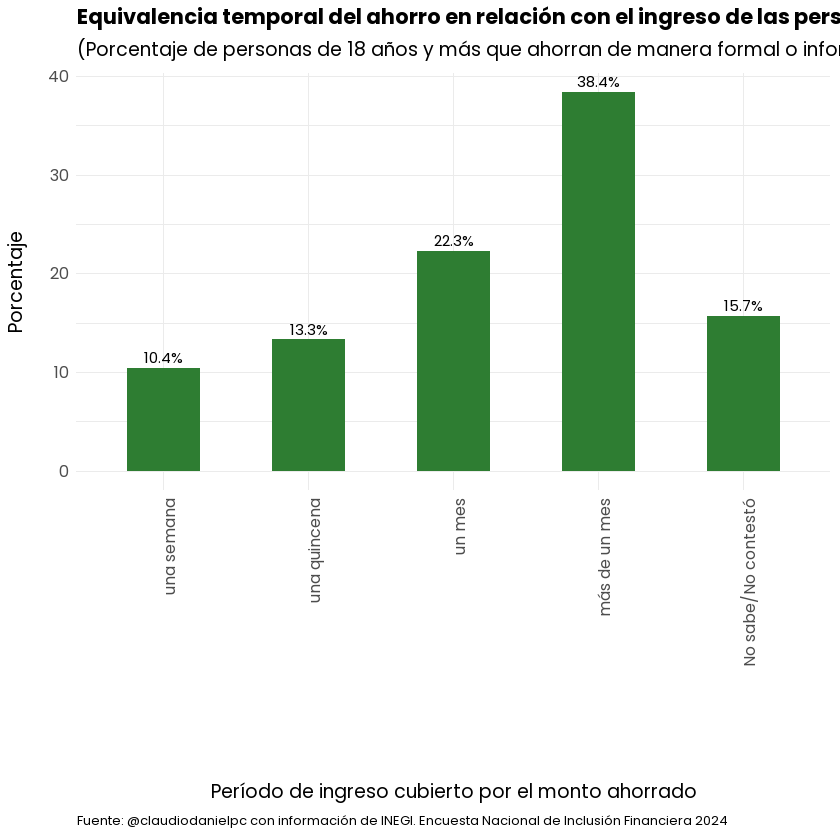

In [11]:
ahorro_ingreso<-dmpers%>%
filter(accion_ahorro==1)%>%
mutate(equivalencia=factor(equivalencia,
levels=c("una semana",
"una quincena",
"un mes",
"más de un mes",
"No sabe/No contestó")))%>%
group_by(equivalencia)%>%
summarise(personas=survey_total(vartype = "cv"),
          pct=survey_prop(vartype = "cv"))%>%
          mutate(pct=round(pct*100,1))
ahorro_ingreso

#Gráfico de ahorro
ahorro_ingreso%>%
ggplot(aes(x=equivalencia, y=pct))+
geom_col(fill="#2E7D32", width=0.5)+
  geom_text(aes(label=paste0(pct,"%")), vjust=-0.5, size=4, family="pop")+
  #scale_y_continuous(breaks=seq(0,100,10), limits=c(0,70))+
  labs(x="Período de ingreso cubierto por el monto ahorrado",
       y="Porcentaje",
       title="Equivalencia temporal del ahorro en relación con el ingreso de las personas de 18 años y más",
       subtitle="(Porcentaje de personas de 18 años y más que ahorran de manera formal o informal)",
       caption="Fuente: @claudiodanielpc con información de INEGI. Encuesta Nacional de Inclusión Financiera 2024")+
  theme_minimal()+
  theme(text = element_text(family = "pop"),
        plot.title = element_text(size=16, face="bold"),
        plot.subtitle = element_text(size=14),
        plot.caption = element_text(size=10, hjust = 0),
        axis.title.x = element_text(size=14),
        axis.title.y = element_text(size=14),
        axis.text.x = element_text(size=12, angle = 90, hjust = 1),
        axis.text.y = element_text(size=12),
        legend.position = "none")

ggsave("equivalencia_ahorro.png",
       width = 12,
       height = 8,
       dpi = 100,
       units = "in",
       device = "png",
       bg="white")

cubre_gastos,personas,personas_cv,pct,pct_cv
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Menos de una semana/ No tiene ahorros,10325619,0.03930737,17.1,0.03665384
"Al menos una semana, pero menos de un mes",11577025,0.03727507,19.1,0.03437843
"Al menos un mes, pero menos de tres meses",19885677,0.02617965,32.9,0.02324508
"Al menos tres meses, pero menos de seis meses",8076572,0.04395980,13.4,0.04140868
Seis meses o más,8605254,0.04316912,14.2,0.03947387
No responde,209710,0.24914973,0.3,0.24828628
No aplica,1817805,0.08785795,3.0,0.08631645


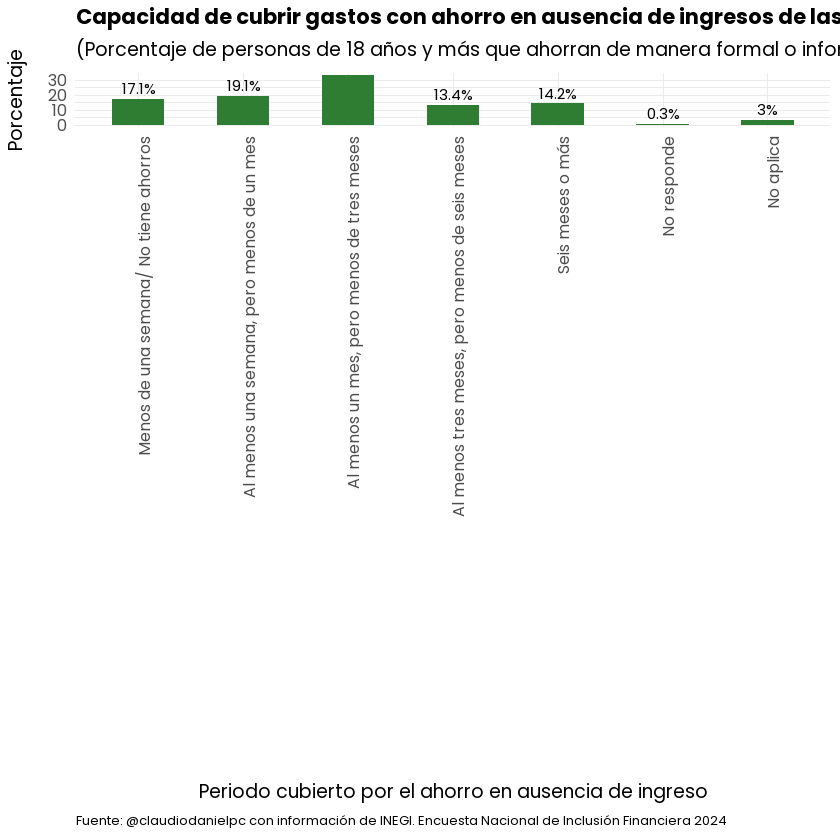

In [12]:
ahorro_gastos<-dmpers%>%
filter(accion_ahorro==1)%>%
mutate(cubre_gastos=factor(cubre_gastos,
                            levels = c("Menos de una semana/ No tiene ahorros",
                                       "Al menos una semana, pero menos de un mes",
                                       "Al menos un mes, pero menos de tres meses",
                                       "Al menos tres meses, pero menos de seis meses",
                                       "Seis meses o más",
                                       "No responde",
                                       "No sabe",
                                       "No aplica")))%>%
group_by(cubre_gastos)%>%
summarise(personas=survey_total(vartype = "cv"),
          pct=survey_prop(vartype = "cv"))%>%
          mutate(pct=round(pct*100,1))
ahorro_gastos


#Gráfico de utilización de ahorro para gastos en caso de no tener ingresos
ahorro_gastos%>%
ggplot(aes(x=cubre_gastos, y=pct))+
geom_col(fill="#2E7D32", width=0.5)+
  geom_text(aes(label=paste0(pct,"%")), vjust=-0.5, size=4, family="pop")+
  #scale_y_continuous(breaks=seq(0,100,10), limits=c(0,70))+
  labs(x="Periodo cubierto por el ahorro en ausencia de ingreso",
       y="Porcentaje",
       title="Capacidad de cubrir gastos con ahorro en ausencia de ingresos de las personas de 18 años y más",
       subtitle="(Porcentaje de personas de 18 años y más que ahorran de manera formal o informal)",
       caption="Fuente: @claudiodanielpc con información de INEGI. Encuesta Nacional de Inclusión Financiera 2024")+
  theme_minimal()+
  theme(text = element_text(family = "pop"),
        plot.title = element_text(size=16, face="bold"),
        plot.subtitle = element_text(size=14),
        plot.caption = element_text(size=10, hjust = 0),
        axis.title.x = element_text(size=14),
        axis.title.y = element_text(size=14),
        axis.text.x = element_text(size=12, angle = 90, hjust = 1),
        axis.text.y = element_text(size=12),
        legend.position = "none")

ggsave("uso_ahorro_gastos.png",
       width = 12,
       height = 10,
       dpi = 100,
       units = "in",
       device = "png",
       bg="white")

instituciones,personas,personas_cv,pct,pct_cv
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
No tiene,15208027,0.03191802,52.5,0.02399729
"Imss, Issste o estatal",12798753,0.03658488,44.2,0.02827630
No sabe/No contestó,794844,0.13840532,2.7,0.13545652
Privada,186977,0.25224392,0.6,0.25183974


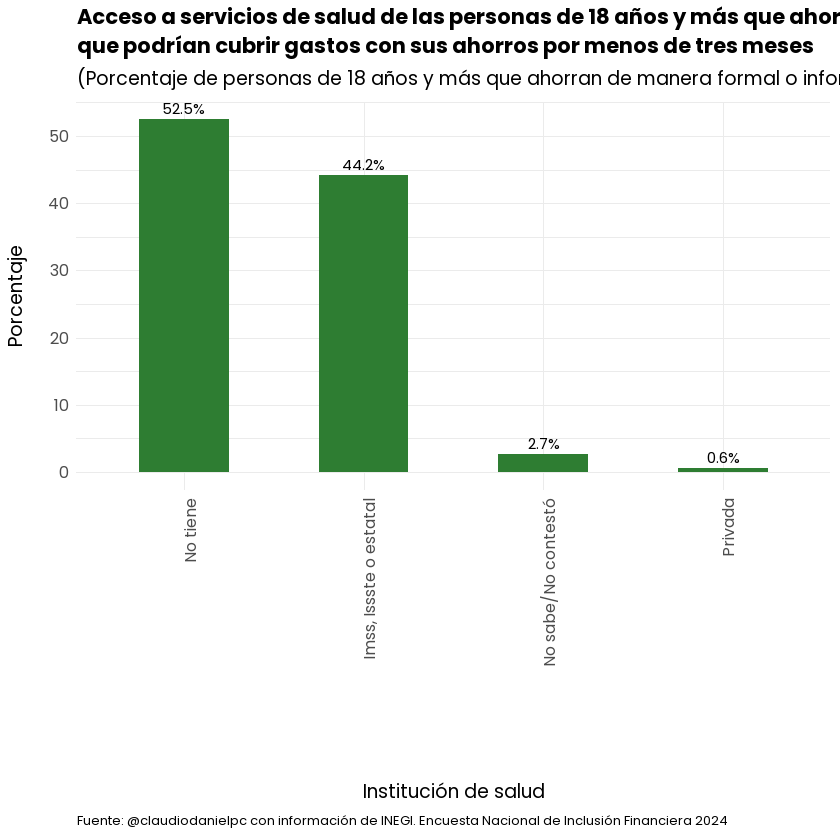

In [51]:
seg_social<-dmpers%>%
filter(accion_ahorro==1)%>%
#filtrar si cubren gastos con ahorro pero por menos de tres meses
filter(p4_10>0 & p4_10<=3)%>%
#Filtrar ocupados
filter(cond_ocup=="Ocupada")%>%
mutate(instituciones=
case_when((p3_13==1 | p3_13==2 | p3_13==3 | p3_13==4) ~ "Imss, Issste o estatal",
          (p3_13==5 | p3_13==6) ~ "Privada",
          (p3_13==7) ~ "No tiene",
          TRUE ~ "No sabe/No contestó"))%>%
group_by(instituciones)%>%
summarise(personas=survey_total(vartype = "cv"),
          pct=survey_prop(vartype = "cv"))%>%
          mutate(pct=round(pct*100,1))%>%
          arrange(desc(pct))
seg_social

##Gráfica de insituciones de salud
seg_social%>%
ggplot(aes(x=reorder(instituciones, -pct), y=pct))+
geom_col(fill="#2E7D32", width=0.5)+
  geom_text(aes(label=paste0(pct,"%")), vjust=-0.5, size=4, family="pop")+
  #scale_y_continuous(breaks=seq(0,100,10), limits=c(0,70))+
  labs(x="Institución de salud",
       y="Porcentaje",
       title="Acceso a servicios de salud de las personas de 18 años y más que ahorran, trabajan y
que podrían cubrir gastos con sus ahorros por menos de tres meses",
       subtitle="(Porcentaje de personas de 18 años y más que ahorran de manera formal o informal y que trabajan)",
       caption="Fuente: @claudiodanielpc con información de INEGI. Encuesta Nacional de Inclusión Financiera 2024")+
  theme_minimal()+
  theme(text = element_text(family = "pop"),
        plot.title = element_text(size=16, face="bold"),
        plot.subtitle = element_text(size=14),
        plot.caption = element_text(size=10, hjust = 0),
        axis.title.x = element_text(size=14),
        axis.title.y = element_text(size=14),
        axis.text.x = element_text(size=12, angle = 90, hjust = 1),
        axis.text.y = element_text(size=12),
        legend.position = "none")

ggsave("seg_social.png",
       width = 12,
       height = 10,
       dpi = 100,
       units = "in",
       device = "png",
       bg="white")

In [13]:
ahorro_informal<-dmpers%>%
group_by(ahorro_inf)%>%
summarise(personas=survey_total(vartype = "cv"),
          pct=survey_prop(vartype = "cv"))%>%
mutate(pct=round(pct*100,1))%>%
janitor::adorn_totals("row")
ahorro_informal

ahorro_inf,personas,personas_cv,pct,pct_cv
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,41276574,0.0175305,43.8,0.01494626
1,52944867,0.0156584,56.2,0.01165232
Total,94221441,0.0331889,100.0,0.02659858


In [14]:
ahorro_inf_gastos<-dmpers%>%
filter(ahorro_inf==1)%>%
mutate(cubre_gastos=factor(cubre_gastos,
                            levels = c("Menos de una semana/ No tiene ahorros",
                                       "Al menos una semana, pero menos de un mes",
                                       "Al menos un mes, pero menos de tres meses",
                                       "Al menos tres meses, pero menos de seis meses",
                                       "Seis meses o más",
                                       "No responde",
                                       "No sabe",
                                       "No aplica")))%>%
group_by(cubre_gastos)%>%
summarise(personas=survey_total(vartype = "cv"),
          pct=survey_prop(vartype = "cv"))%>%
          mutate(pct=round(pct*100,1))%>%
          janitor::adorn_totals("row")

ahorro_inf_gastos

cubre_gastos,personas,personas_cv,pct,pct_cv
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Menos de una semana/ No tiene ahorros,9328585,0.04115504,17.6,0.03748016
"Al menos una semana, pero menos de un mes",10366114,0.04025767,19.6,0.03648238
"Al menos un mes, pero menos de tres meses",17818391,0.02738570,33.7,0.02449245
"Al menos tres meses, pero menos de seis meses",6872354,0.04704020,13.0,0.04463747
Seis meses o más,6929211,0.04855215,13.1,0.04435969
No responde,156762,0.30112030,0.3,0.30043455
No aplica,1473450,0.09653532,2.8,0.09536733
Total,52944867,0.60204638,100.1,0.58325404


In [15]:
#A qué hogares corresponden los ahorros

pers_ahorro<-modulo%>%
select(llaveviv,llavehog,accion_ahorro)%>%
 filter(accion_ahorro == 1) %>%
  distinct(llaveviv, llavehog, .keep_all = TRUE)


#Pegar a la tabla de hogares

hogares_ahorro<-hogares%>%
left_join(pers_ahorro, by = c("llaveviv", "llavehog"))


In [17]:
dmhog<-hogares_ahorro%>%
as_survey_design(ids = "upm_dis",
            weights = "fac_hog",
            strata="est_dis")

In [18]:
dmhog%>%
group_by(accion_ahorro)%>%
summarise(hogares=survey_total(vartype = "cv"),
          pct=survey_prop(vartype = "cv"))%>%
          mutate(pct=round(pct*100,1))

accion_ahorro,hogares,hogares_cv,pct,pct_cv
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,25368077,0.01208065,63.8,0.008781361
NA,14383050,0.01742221,36.2,0.015488108
